In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of Lyrics from Historical Billboard Top 100 Singles
### Kenta Burpee, James Jagielski, Satchel Sevenau

## Introduction
Throughout the decades, popular music has changed significantly. Artists have gained and lost popularity, and genres have risen and fallen. However, one thing that remains relatively constant is that popular songs tend to contain catchy, repetitive phrases, often repeating the song title in them. 

This leads to the central question of our project: among the Billboard top 100 singles of the last five decades, what are the trends that can be seen in how often a song title is mentioned in its lyrics? Through answering this question, we aim to illustrate how the frequency of song titles mentioned in lyrics have changed over the years, find the distribution of title-in-lyrics frequencies for the data set, and find top songs and artists who repeat titles in their lyrics the most.

Gathering and analyzing this information requires four major steps. First, collecting a list of historical Billboard top 100 songs from Wikipedia. Second, going through that list and finding lyrics for each song from Genius. Third, taking this information to find the number of times the title is mentioned in the lyrics for each song and converting it to a list containing information for each song. Finally, graphing the data in different ways to analyze its patterns.



## Methodology
### The Songs
To answer our central question we need two critical pieces of data: the songs in the Billboard top 100 for a range of years and the lyrics of each song. We decided to use Wikipedia to get a list of top songs because they had a page called “Billboard Year-End Top 100 Singles of (year)” for each year and an accessible API we could use to scrape the HTML of each page.

The code below imports functions from the file wiki_data.py that scrape song data from Wikipedia and write it to a CSV file. The function get_all_top_songs takes two arguments that represent a range of years to get a list of top 100 songs from. In our case, we want the last 52 years, so our inputs are 1970 to 2021, which returns a list of 5200 songs, where each song is a list in the form [Title, Artist, Year, Rank]. "Baby" by Justin Bieber was number 44 in 2010, so the list for that song would be [Baby, Justin Bieber, 2010, 44]. In order to get this list of songs, the function accesses the Wikipedia page for each year using the wikipedia package and parses the HTML for the title, artist, and rank of each song. In some special cases, artist names are replaced with alternates (e.g. Tupac Shakur to 2Pac or Sean Combs to Diddy) in order to make accessing the lyrics later on easier.

The function write_songs_to_file takes the list generated by get_all_top_songs and stores the information into a CSV file called songs.csv.

#### WARNING: Running the code cell below will take 3-5 minutes. The output will be the same as the data currently in songs.csv.

In [ ]:
import wiki_data
song_list_all_years = wiki_data.get_all_top_songs(1970, 2021)
wiki_data.write_songs_to_file(song_list_all_years)

The following is a taste of the information stored in songs.csv generated by wiki_data.py:

In [2]:
with open("songs.csv", newline="") as my_file:
    for _ in range(10):
        line = my_file.readline()
        print(line)

Title,Artist,Year,Rank

Bridge Over Troubled Water,Simon & Garfunkel,1970,1

(They Long to Be) Close to You,The Carpenters,1970,2

American Woman,The Guess Who,1970,3

Raindrops Keep Fallin' on My Head,B.J. Thomas,1970,4

War,Edwin Starr,1970,5

Ain't No Mountain High Enough,Diana Ross,1970,6

I'll Be There,The Jackson 5,1970,7

Get Ready,Rare Earth,1970,8

Let It Be,The Beatles,1970,9



### The Lyrics

Now that we have a list of songs, we need to get the lyrics for each song. We achieved this by accessing genius.com for lyrics, using the requests library to get the HTML and the BeautifulSoup library to parse it for the lyrics. In order to access the lyrics for each song, we needed to format each song in a way that could be turned into a Genius URL. The first step in this process was to convert songs.csv (which contains information scraped from Wikipedia) into a list of lists containing song information. Then, we called the function format_list_for_genius to format the title and artist in a way that could be pasted into a URL. This involved removing special characters, punctuation, and capitalization, as well as replacing hyphens with spaces. 

Below is a sample list containing information for two songs and the formatted output for the songs.

In [3]:
from genius import format_list_for_genius

sample_list = [["Whatcha Say", "Jason Derulo", "2010", "43"], ["Baby", "Justin Bieber", "2010", "44"]]
jason_justin_formatted = format_list_for_genius(sample_list)
print(jason_justin_formatted)

[['whatcha-say', 'jason-derulo'], ['baby', 'justin-bieber']]


The get_lyrics function then retrieves the lyrics for a particular song given a list containing the formatted title and artist. Since all Genius lyrics URLs are in the form "genius.com/ + ARTIST- + TITLE- + lyrics", these formatted lists ensured that we were accessing the correct pages. Below is an example of lyrics retrieved for Baby by Justin Bieber, formatted into a Genius-URL-friendly list above.

In [4]:
from genius import get_lyrics
justin_lyrics = get_lyrics(jason_justin_formatted[1])
print(justin_lyrics[0:501] + "...\n")

[Produced by The-Dream and Tricky Stewart] [Intro: Justin Bieber] Oh, woah Oh, woah Oh, woah [Verse 1: Justin Bieber] You know you love me, I know you care Just shout whenever and I'll be there You want my love, you want my heart And we will never, ever, ever be apart Are we an item? Girl, quit playin' We're just friends, what are you sayin'? Said "There's another," and looked right in my eyes My first love broke my heart for the first time, and I was like [Chorus: Justin Bieber] Baby, baby, baby...




The function write_lyrics_to_file from genius.py does all of this for all 5200 songs. It calls helper functions to convert songs.csv into a list, converts the list to a URL-friendly format, retrieves lyrics for all songs, and finally writes all of this data into a CSV file called songs_with_lyrics.csv.

#### WARNING: Running the code cell below may take 2-3 **hours**. The output will be the same as the data currently in songs_with_lyrics.csv

In [ ]:
from genius import write_lyrics_to_file
write_lyrics_to_file()

After saving the lyrics in songs_with_lyrics.csv, we realized that the lyrics for some of the songs were missing. Upon further investigation, we found that this was caused by a discrepency between how songs were listed in Wikipedia and in Genius. For instance, Wikipedia says that the song "Get Low" is by Lil Jon, but Genius says that the artist is "Lil Jon & the East Side Boyz". Therefore, we were not able to retrieve those lyrics because we had the wrong URL.

The code cell below calculates the percentage of the 5200 songs we are missing lyrics for. We decided that the number was low enough that it did not cause any significant changes in trends we saw in our data.

In [5]:
import finder
song_list_by_song = finder.get_total_song_data("songs_with_lyrics.csv", by_song=True)
count = 0
for song in song_list_by_song:
    if song[4] == -1:
        count += 1
print("Missing lyrics for " + str(round(count/52, 2)) + "% of the total songs")

Missing lyrics for 3.79% of the total songs


### The Analysis
The last thing we needed before graphing our data was to get the frequency of each song's title within its lyrics. We did this by simply taking the title formatted to lower case and counting how many times it appears within the lyrics formatted to lower case. If the song was one of the songs we weren't able to retrieve lyrics for, we set its title frequency to -1. The function below copied from finder.py does this process for one song. The song argument is a list containing [Title, Artist, Year, Rank, Lyrics], and the function returns a number representing the number of times the title appears in the lyrics.

In [6]:
def title_in_lyrics_one_song(song):
    title = song[0]
    lyrics = song[4]
    if '(' in title:
        title = title[0:title.find("(") - 1]
    if len(lyrics) == 0:
        return -1
    return lyrics.lower().count(title.lower())

The function get_total_song_data, also from finder.py, goes through this process for all 5200 songs and returns a list of lists containing the title, artist, year, rank, and frequency of the title in the lyrics for each song. The argument by_song determines whether each list within the outer list represents a song (by_song=True) or a category of data (by_song=False). 

In [7]:
from genius import csv_to_list
def get_total_song_data(path, by_song=False):
    total_song_data = []
    song_list = csv_to_list(path)
    if by_song:
        for song in song_list:
            total_song_data.append([song[0], song[1], song[2], song[3], title_in_lyrics_one_song(song)])
    else:
        titles = []
        artists = []
        years = []
        ranks = []
        frequencies = []
        for song in song_list:
            titles.append(song[0])
            artists.append(song[1])
            years.append(song[2])
            ranks.append(song[3])
            frequencies.append(title_in_lyrics_one_song(song))
        total_song_data = [titles, artists, years, ranks, frequencies]

    return total_song_data

This function is used to graph and analyze our data in the results section of this essay.

## Results
The first step in visualizing our data was to use finder.py (functions explained in the methodology section) to get a list containing song information. The code cell below calls get_total_song_data from finder.py to get the data and organizes it by column. We also created several lists containing ranges of numbers that we used later for our visualizations, like a list of possible rankings (1-100) or years (1970-2021).

In [8]:
import finder
import matplotlib.pyplot as plt
song_list = finder.get_total_song_data("songs_with_lyrics.csv") #[Title, Artist, Year, Rank, Frequency]
titles = song_list[0]
artists = song_list[1]
possible_rankings = list(range(1, 101))
possible_years = list(range(1970, 2022))
possible_decades = list(range(1970, 2020, 10))
frequencies = song_list[4]
possible_frequencies = list(range(max(frequencies)))

### Percentage of Songs that Mention Title At Least Once
We first investigated what proportion of songs contain the title in the lyrics at least once, and how that changes over the years. The code below counts the number of songs that contain the title in the lyrics for each year, and displays the data.

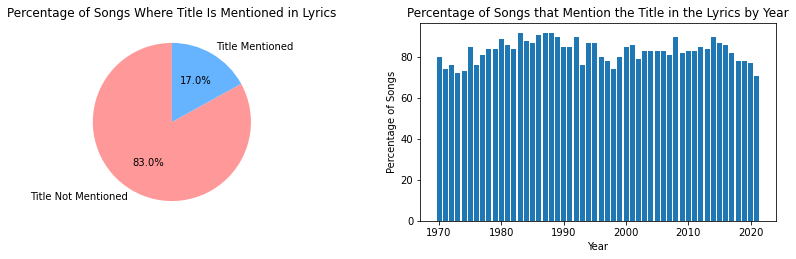

In [9]:
percent_mentions_by_year = []
for i in range(52):
    number_mentioned_in_year = 0
    for j in range(100):
        if frequencies[100*i+j] > 0:
            number_mentioned_in_year += 1
    percent_mentions_by_year.append(number_mentioned_in_year)

my_fig = plt.figure(figsize=(14, 8))
percent_yearly_plot = my_fig.add_subplot(222)
percent_yearly_plot.bar(possible_years, percent_mentions_by_year)
plt.title("Percentage of Songs that Mention the Title in the Lyrics by Year")
plt.xlabel("Year")
plt.ylabel("Percentage of Songs")

percent_total_plot = my_fig.add_subplot(221)
total_mentions_all_years = sum(percent_mentions_by_year)
pie_elements = [total_mentions_all_years, 5200 - total_mentions_all_years]
colors = ["#ff9999", "#66b3ff"]
labels = {"Title Mentioned", "Title Not Mentioned"}
percent_total_plot.pie(pie_elements, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.title("Percentage of Songs Where Title Is Mentioned in Lyrics");

The pie chart shows that 83% of the 5200 songs we looked at mention the song title in its lyrics, and 17% do not. The bar graph on the right shows that when this percentage is split up by year, it stays relatively consistent. Each year, 70-90% of the Billboard top 100 songs contain its title in the lyrics, and there is no discernable upward or downward trend.

### Distribution of Title Frequencies in Songs
Next, we looked at the frequency at which the title is mentioned in a song's lyrics and what the distribution of frequencies in the data set is. Below are two graphs that show the frequency of the title in the lyrics versus the number of songs for that frequency.

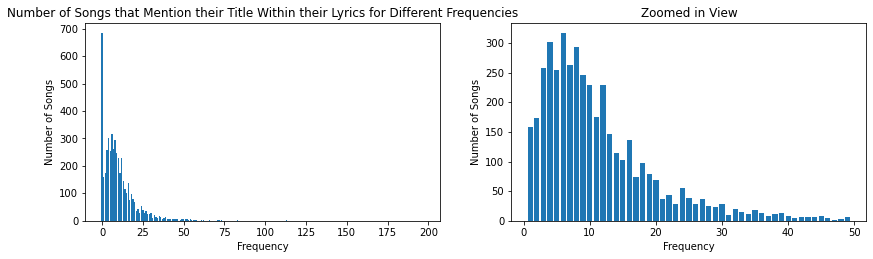

In [10]:
frequency_list = []
for i in range(max(frequencies)):
    frequency_list.append(frequencies.count(i))
    
my_figure = plt.figure(figsize=(14, 8))
all_freq_plot = my_figure.add_subplot(221)
all_freq_plot.bar(possible_frequencies, frequency_list)
plt.title("Number of Songs that Mention their Title Within their Lyrics for Different Frequencies")
plt.xlabel("Frequency")
plt.ylabel("Number of Songs")

low_freq_plot = my_figure.add_subplot(222)
low_freq_plot.bar(possible_frequencies[1:50], frequency_list[1:50])
plt.title("Zoomed in View")
plt.xlabel("Frequency")
plt.ylabel("Number of Songs");

The graph on the left shows all the data, while the graph on the right shows frequencies from one to fifty. From this data, it is clear that zero is the mode for frequencies. This is expected because 17% of the songs did not contain the title in the lyrics at all, and each song that contains its title in the lyrics are spread across the board. The data also shows that for songs that do mention the title in the lyrics, the number of songs peaks at 8-10 mentions and exponentially decreases. This is also expected because it makes sense that there are more songs that repeat the title a few times rather than dozens of times.

### Average Title Frequency by Ranking
Next, we analyzed what kind of effect the frequency of the title in the lyrics had in its position within the Billboard top 100. To do so, we took the mean number of title mentions per song for each rank (code below) and created a bar graph representing the rankings and average number of title mentions.

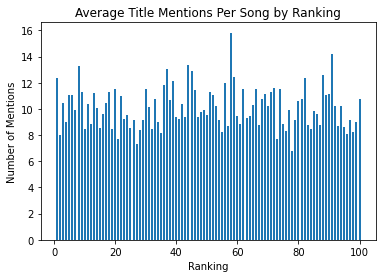

In [11]:
average_frequencies = []
for i in range(100):
    total_mentions = 0
    for j in range(i, 5200, 100):
        if frequencies[j] != -1:
            total_mentions += frequencies[j]
    average_frequencies.append(round(total_mentions/52, 2))
    
plt.bar(possible_rankings, average_frequencies, width=0.655)
plt.title("Average Title Mentions Per Song by Ranking")
plt.xlabel("Ranking")
plt.ylabel("Number of Mentions");

The graph shows that for the years 1970 to 2021, there is no correlation between the number of times a song title is mentioned in its lyrics and its position in the top 100. The average number of mentions for all of the rankings seem to be in the 8-10 range, which matches the conclusion drawn from the title frequency distribution graph of the previous section.

### Average Title Frequency by Year
We then investigated how the average number of title mentions in the lyrics have changed over the years. First, we created a list containing the average title frequency per song by year (code below) and produced two graphs, one showing average title mentions by year, and the other, average title mentions by decade.

Average Title Mentions in the 1970s: 8.15
Average Title Mentions in the 2010s: 11.76 



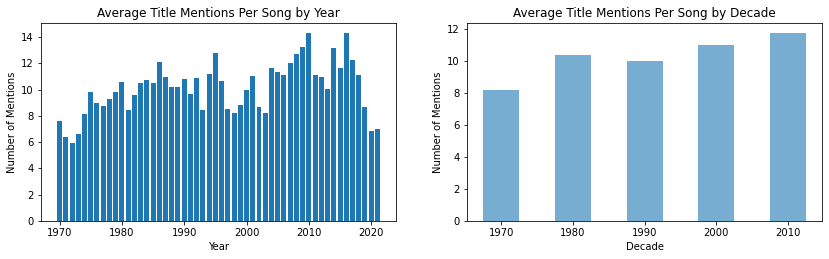

In [12]:
frequency_by_year = []
for i in range(0, 5200, 100):
    mention_count = 0
    for j in range(i, i+ 100):
        if frequencies[j] != -1:
            mention_count += frequencies[j]
    frequency_by_year.append(round(mention_count/100, 2))

myfig = plt.figure(figsize=(14, 8))
year_plot = myfig.add_subplot(221)
year_plot.bar(possible_years, frequency_by_year)
plt.title("Average Title Mentions Per Song by Year")
plt.xlabel("Year")
plt.ylabel("Number of Mentions")

frequency_by_decade = []
for i in range(5):
    frequency_by_decade.append(round(sum(frequency_by_year[10*i:10*i + 10])/10, 2))

decade_plot = myfig.add_subplot(222)
decade_plot.bar(possible_decades, frequency_by_decade, width=5, alpha=0.6)
plt.title("Average Title Mentions Per Song by Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Mentions")
print("Average Title Mentions in the 1970s:", frequency_by_decade[0])
print("Average Title Mentions in the 2010s:", frequency_by_decade[-1], "\n")

The average mentions by year graph shows that there is an increasing trend of mentions per year. Although there are fluctuations and the number of title mentions does not increase every single year, there is a generally increasing trend. 

This trend is more evident in the graph on the right, which depicts the average title mentions per song by decade. Here, it is clear that the title of a song is mentioned in a song's lyrics more times per song in recent years than in the past. The average number of mentions per song in the 1970s was 8.15 times, while the average in the 2010s was 11.76 times.

The maximum title mentions in a song's lyrics by year (graph below) also shows a similar trend to the average. Songs from recent years seem to mention their title in the lyrics more times, and more songs that have more than one hundred mentions have appeared much more frequently since the early 2000s. 

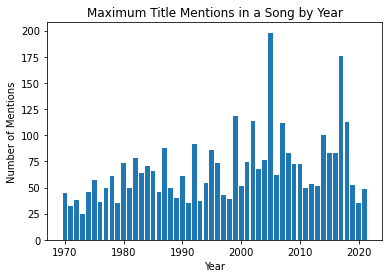

In [13]:
maximum_song_frequency_by_year = []
for i in range(52):
    maximum_song_frequency_by_year.append(max(frequencies[100*i: 100*i + 100]))
    
plt.bar(possible_years, maximum_song_frequency_by_year)
plt.title("Maximum Title Mentions in a Song by Year")
plt.xlabel("Year")
plt.ylabel("Number of Mentions");

### Songs that Repeat the Title in the Lyrics the Most
We produced a list of top 20 songs that repeat the title in the lyrics the most. The code below finds the maximum number of title mentions in the whole dataset and displays the song title and artist along with the number of mentions. It repeats this process twenty times to produce the output. The code also makes sure that a song that appears twice in the list is not counted twice.

In [14]:
from better_profanity import profanity
freq_temp = frequencies.copy()
print("Top 20 songs where the title is mentioned the most:\n")
previous_title = None
count = 0
while count < 20:
    mfi = freq_temp.index(max(freq_temp))
    if titles[mfi] != previous_title:
        print(f"{count + 1}. \"{profanity.censor(titles[mfi])}\" by {artists[mfi]} ({max(freq_temp)} mentions)")
        count += 1
    previous_title = titles[mfi]
    freq_temp[mfi] = 0
print()

Top 20 songs where the title is mentioned the most:

1. "O" by Omarion (198 mentions)
2. "Down" by Marian Hill (176 mentions)
3. "Who Dat" by JT Money (118 mentions)
4. "Baby" by Ashanti (114 mentions)
5. "Thunder" by Imagine Dragons (113 mentions)
6. "Walk It Out" by Unk (112 mentions)
7. "My ****" by YG (100 mentions)
8. "Jump" by Kris Kross (92 mentions)
9. "Bad" by Michael Jackson (88 mentions)
10. "Baby" by Brandy Norwood (86 mentions)
11. "Say" by John Mayer (83 mentions)
12. "Watch Me (Whip/Nae Nae)" by Silentó (83 mentions)
13. "Work" by Rihanna (80 mentions)
14. "Get Down on It" by Kool & the Gang (78 mentions)
15. "Taste" by Tyga (77 mentions)
16. "Why" by Jadakiss (76 mentions)
17. "No" by Meghan Trainor (75 mentions)
18. "Stutter" by Joe (74 mentions)
19. "Call Me" by Blondie (73 mentions)
20. "Doin' It" by LL Cool J (73 mentions)



From this list, it is clear that songs with short titles, often one word, are repeated the most often. This makes sense because it is easier to repeat a single word many times in a song rather than a longer phrase. In the case of "O" by Omarion, our algorithm simply looked for the letter O, so it makes sense that it comes out at the top of the list. In addition, most of these top songs are from the 2000s or 2010s, further bolstering the conclusions we drew from the title mentions versus year information we looked at in the previous section. Surprisingly, the two songs titled "Baby" in this top 20 list were not by Justin Bieber (the Justin Bieber song contained the word "baby" 56 times).

### Artists that Repeat Their Song Titles in Their Lyrics the Most
We also produced a list of top 10 artists that repeat their titles in their lyrics the most. Since this data could be skewed by a single appearance in the top 100, we only looked at artists who appeared in the top 100 at least twice. Below is the code and the output.

In [15]:
artists_and_mentions = {}
for i in range(5200):
    if artists[i] not in artists_and_mentions:
        artists_and_mentions[artists[i]] = [frequencies[i], 1]
    else:
        artists_and_mentions[artists[i]][0] += frequencies[i]
        artists_and_mentions[artists[i]][1] += 1
for musician in artists_and_mentions:
    artists_and_mentions[musician].append(round(artists_and_mentions[musician][0]/artists_and_mentions[musician][1], 2))
    
a_and_m = artists_and_mentions.copy()
print("Top 10 artists who mention the title in the lyrics on average the most")
print("(and have appeared in the top 100 more than once):\n")
for i in range(10):
    max_number = None
    max_artist = None
    for musician in a_and_m:
        if max_number is None or a_and_m[musician][2]  > max_number and a_and_m[musician][1] > 1:
            max_artist = musician
            max_number = a_and_m[musician][2]
    print(f"{i+1}. {max_artist} ({max_number} mentions)")
    a_and_m[max_artist][2] = 0
print()

Top 10 artists who mention the title in the lyrics on average the most
(and have appeared in the top 100 more than once):

1. Silentó (83.0 mentions)
2. Omarion (66.33 mentions)
3. Tyga (65.0 mentions)
4. YG (58.5 mentions)
5. Unk (57.5 mentions)
6. Jay Sean (55.67 mentions)
7. O.T. Genasis (48.0 mentions)
8. D'Angelo (45.0 mentions)
9. Ella Mai (43.67 mentions)
10. Los del Río (43.0 mentions)



## Conclusion

Our key insight from our results was that the number of times song titles are mentioned in lyrics of popular songs have increased in recent years. This was evident from analyzing the graphs depicting the average title mentions per song over the years, the maximum title mentions over the years, and the list of top songs with the highest title frequencies. However, we also saw that the percentage of songs that mention titles in lyrics hasn't really changed over the last five decades. Therefore, we can conclude that while more recent songs repeat titles in lyrics more often, this is due to the increase in number of times the title is repeated per song, not the number of songs that mention the title in the lyrics at all.

While scraping websites for song lyrics don't really have any major ethical implications, data scraping in general does have some ethical implications. Since a lot of personal information can be accessed relatively easily online, people could write algorithms to scrape personal information of large groups of people and use it to cause harm. Therefore, when scraping data, it is important to consider how the data collected may be misused.

One lesson we learned is that it is important to test small components of the code before testing the entire implementation. Since we were retrieving large amounts of data for this project, it was important to test our code with smaller data sets to make sure that it was doing what we wanted to before we moved on to the next part of the project.

The biggest challenge for this project was formatting our data to be compatible between two different APIs. Since we used Wikipedia to get songs and Genius to get lyrics, formatting the Wikipedia data to work with Genius URLs was quite challenging and took a lot of attention to detail. 

There are a number ways we could extend this project if we had more time. First, we can try to capture 100% of the lyrics from the top 100 songs instead of 97% by making the formatting for Genius more robust. Alternatively, we could take the data we already have and try to use it to predict what the title of the song is based on the lyrics. With an additional API, we could also try to see the number of mentions based on genre of music. 